In [1]:
import os
os.environ['OMP_NUM_THREADS'] = "8"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE
%matplotlib inline

/Users/oliverpaul/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### Importing data

In [2]:
train = pd.read_csv("train.csv", index_col = 0)
sample = pd.read_csv("sampleSubmission.csv")
test = pd.read_csv("test.csv", index_col = 0)

### Checking correlation within training set

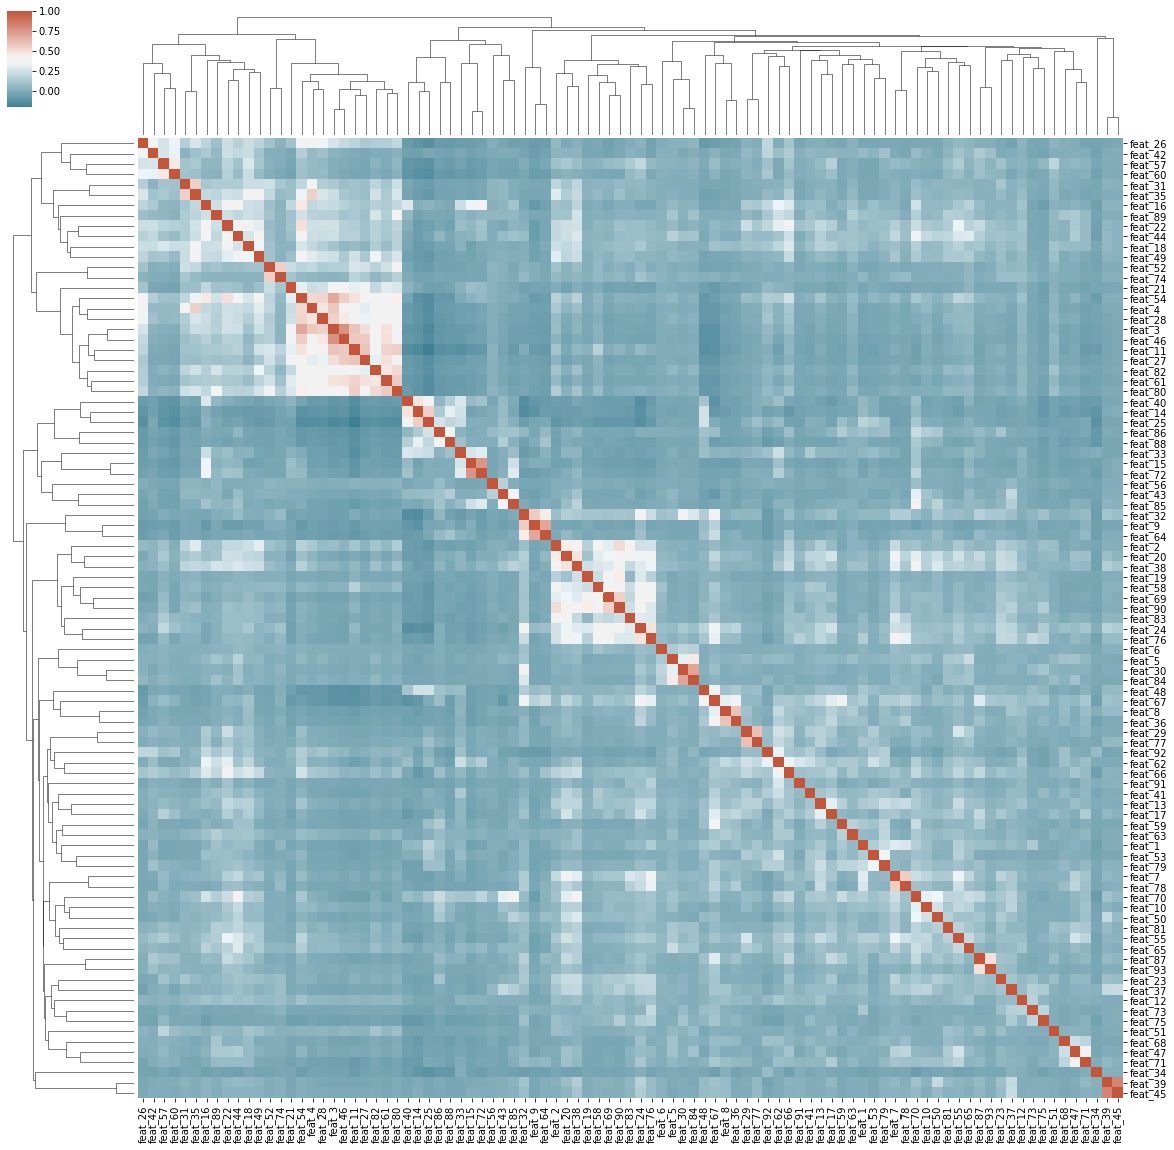

In [3]:
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
ax = sns.clustermap(train.corr(), figsize= (20,20), cmap = cmap, annot=False).ax_row_dendrogram.set_visible(True)

There is little correlation between features in the dataset

### Checking distribution of target variables for imbalance 

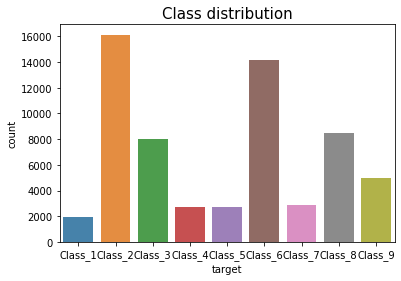

In [4]:
ax = sns.countplot(x='target', data=train, alpha=0.9, palette="tab10").set_title('Class distribution', size=15)

Clearly we have multiclass imbalance... we can see if upsampling minority classes or using SMOTE will improve performance 

### Checking feature values with class labels 

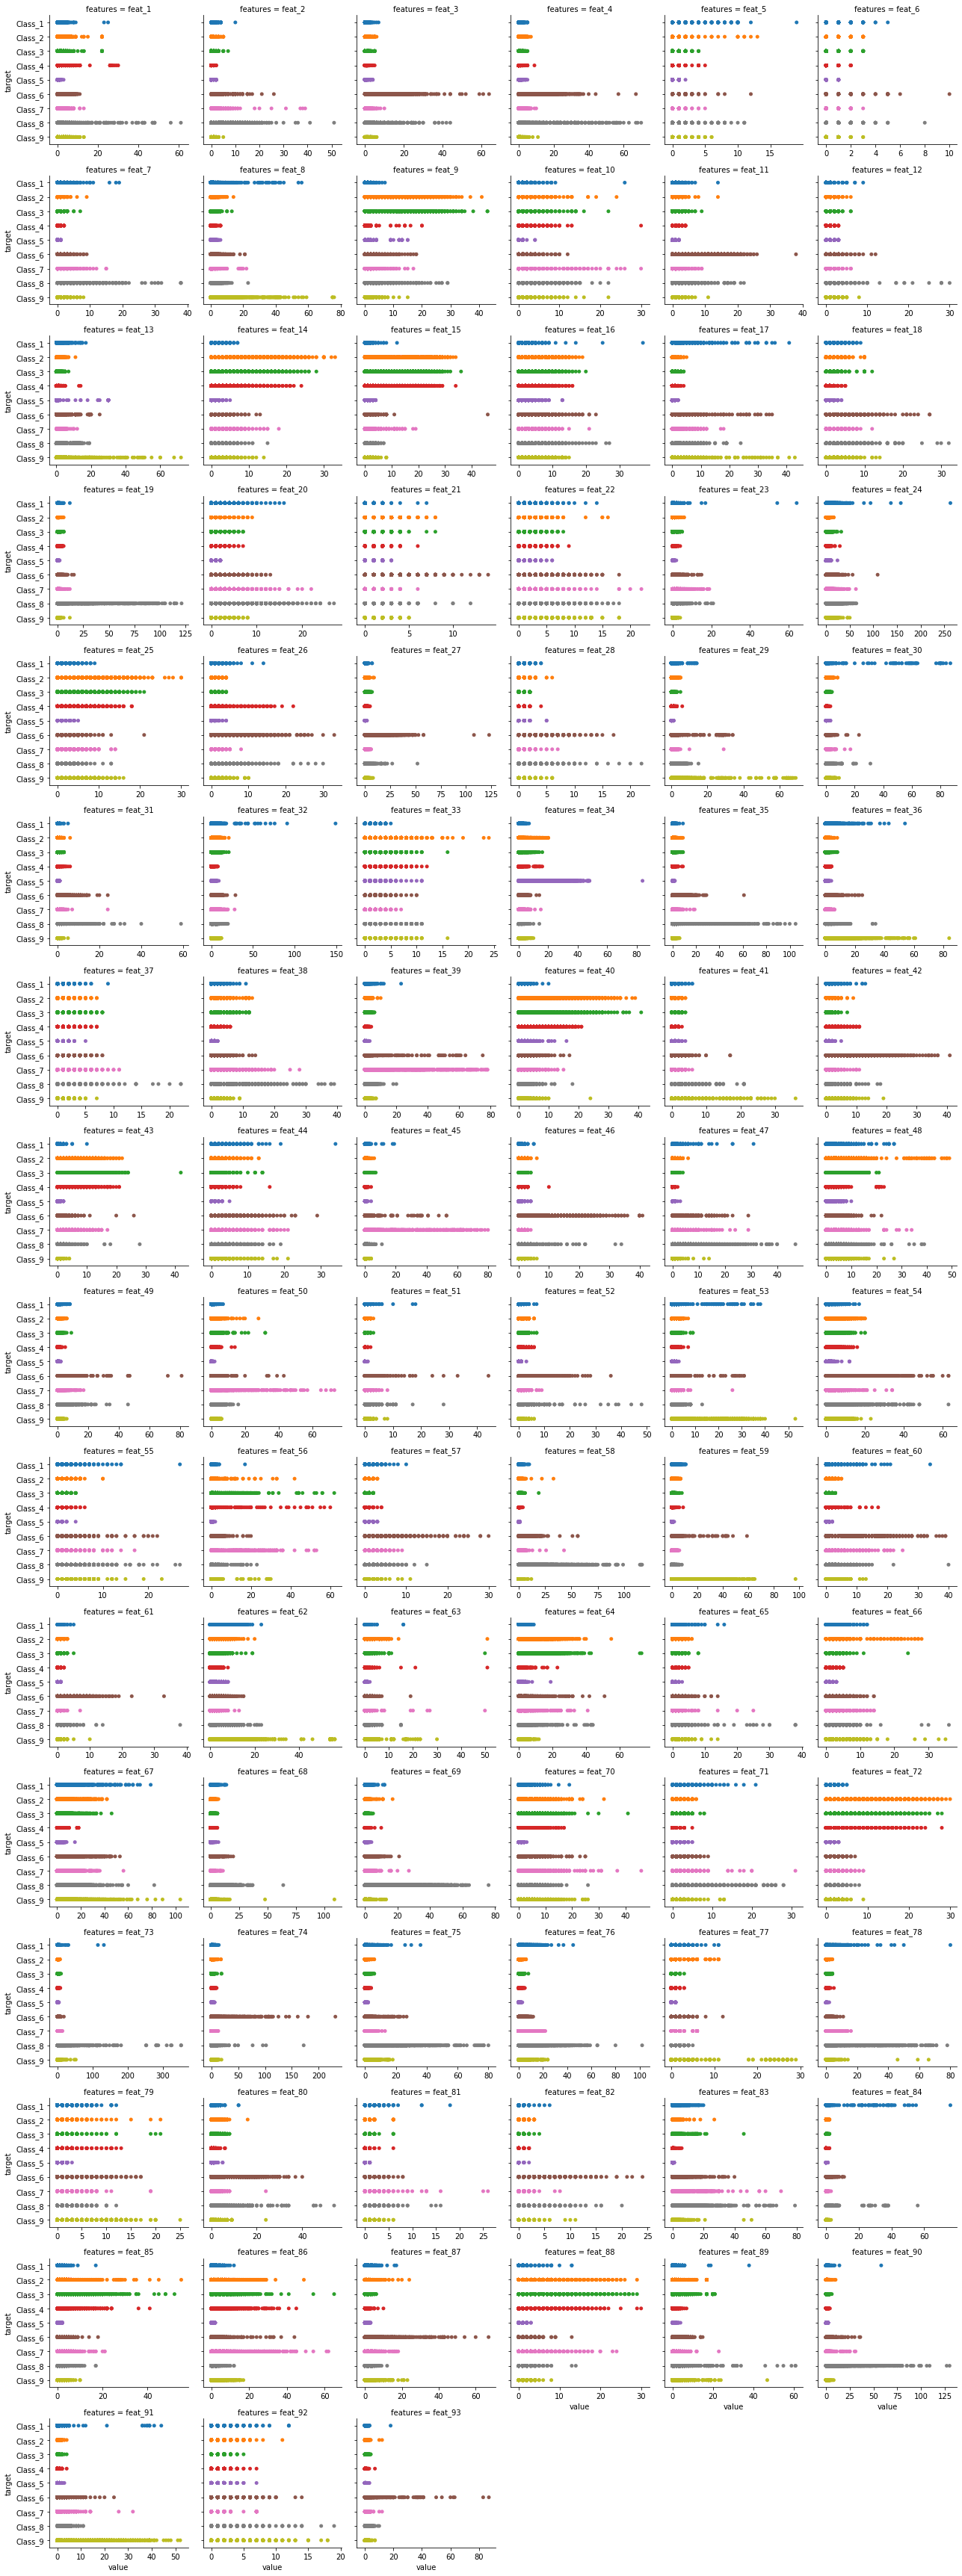

In [13]:
train_wide = train.melt(id_vars=['target'], var_name='features')
sns.catplot(data=train_wide, x='value', y='target', col='features', 
            col_wrap=6, 
            height=3, 
            aspect=1, 
            sharex=False,
            jitter=False)

### Building stacking model 

In [5]:
#converting target variables to integers **not needed for current setup**

#target_var = {
#    'Class_1' : 1,
#    'Class_2' : 2,
#    'Class_3' : 3,
#    'Class_4' : 4,
#    'Class_5' : 5,
#    'Class_6' : 6,
#    'Class_7' : 7,
#    'Class_8' : 8,
#    'Class_9' : 9
#}

#train['target'] = train['target'].map(target_var)

In [6]:
y_train = train['target'].ravel()
train = train.drop(['target'], axis=1)
x_train = train.values 
x_test = test.values 

Sklearn helper class

In [8]:
SEED = 0 
NFOLDS = 5 
shuffle = True # wana shuffle data?
n_classes = len(np.unique(y_train))

kf = StratifiedKFold(n_splits = NFOLDS, shuffle = shuffle, random_state = SEED)

class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)    

Stacking function 

In [10]:
def stack(clf, x_train, y_train, x_test):
    stack_train = np.zeros((x_train.shape[0], n_classes))
    stack_test = np.zeros((x_test.shape[0], n_classes))
    stack_test_temp = np.zeros((NFOLDS, x_test.shape[0], n_classes))
         

    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        stack_train[test_index] = clf.predict(x_te)
        stack_test_temp[i, :] = clf.predict(x_test)

    stack_test[:] = np.mean(stack_test_temp, axis=0)
    return stack_train, stack_test

Model params

In [11]:
lr_params = {
    'multi_class': 'multinomial',
    'solver' : 'newton-cg'
}

nb_params = {}

rf_params = {
    'n_jobs': -1,
    'n_estimators': 1000,
     'max_features': 'auto',
    'max_depth': 50,
    'min_samples_leaf': 1,
    'min_samples_split': 10,
    'bootstrap': False
}

et_params ={'random_state': 0,
           'n_estimators': 500,
           'n_jobs': -1
}

knn_16_params = {'n_neighbors': 16,
           'n_jobs': -1
}

Initialise models 

In [12]:
lr = SklearnHelper(clf=LogisticRegression, seed=SEED, params=lr_params)
nb = SklearnHelper(clf=MultinomialNB, seed=SEED, params=nb_params)
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
knn_16 = SklearnHelper(clf=KNeighborsClassifier, seed=SEED, params=knn_16_params)

Call stacking function for base learners 

In [13]:
nb_stack_train, nb_stack_test = stack(nb,x_train, y_train, x_test)
lr_stack_train, lr_stack_test = stack(lr,x_train, y_train, x_test)
rf_stack_train, rf_stack_test = stack(rf, x_train, y_train, x_test)
et_stack_train, et_stack_test = stack(et, x_train, y_train, x_test)
knn_16_stack_train, knn_16_stack_test = stack(knn_16, x_train, y_train, x_test)

Create pandas dataframe for base learners and look at model correlations 

In [25]:
#ravelling creates columns 9 times longer than training set, but ok for corplot

base_model_df_train = pd.DataFrame( {'RandomForest': rf_stack_train.ravel(),
     'Neive Bayes': nb_stack_train.ravel(),
     'Softmax Regression': lr_stack_train.ravel(),
     'Extra Trees': et_stack_train.ravel(),
     'KNN 16': knn_16_stack_train.ravel()
    })

base_model_df_test = pd.DataFrame( {'RandomForest': rf_stack_test.ravel(),
     'Neive Bayes': nb_stack_test.ravel(),
     'Softmax Regression': lr_stack_test.ravel(),
     'Extra Trees': et_stack_test.ravel(),
     'KNN 16': knn_16_stack_test.ravel()
    })


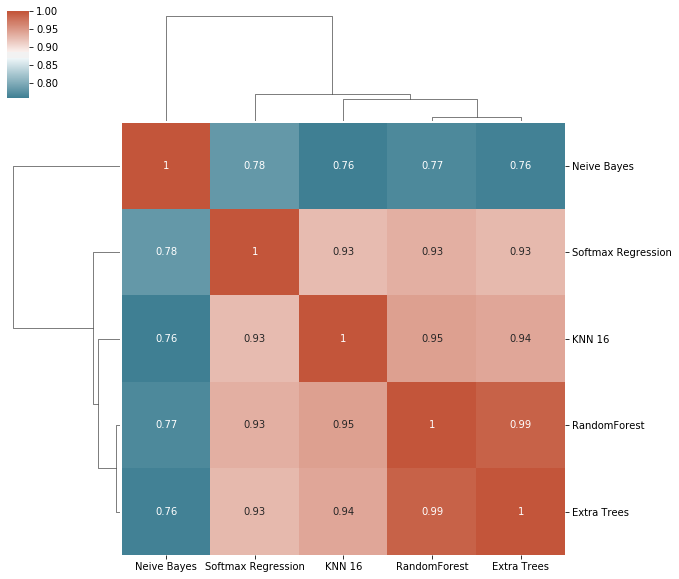

In [26]:
#corrlation map train

cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
ax = sns.clustermap(base_model_df_train.corr(), figsize= (10,10), cmap = cmap, annot=True).ax_row_dendrogram.set_visible(True)

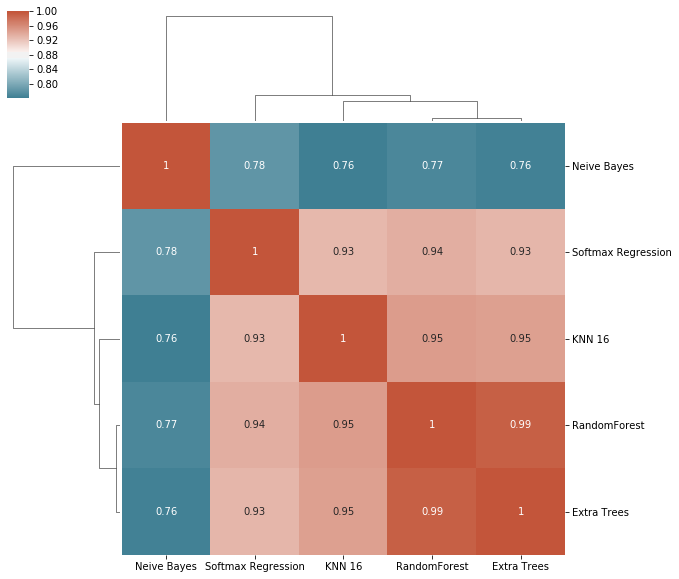

In [27]:
#corrlation map test

cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
ax = sns.clustermap(base_model_df_test.corr(), figsize= (10,10), cmap = cmap, annot=True).ax_row_dendrogram.set_visible(True)

merging base learner train and test sets

In [16]:
s_train = np.concatenate((rf_stack_train, lr_stack_train, nb_stack_train, et_stack_train, knn_16_stack_train), axis=1)
s_test = np.concatenate((rf_stack_test, lr_stack_test, nb_stack_test, et_stack_test, knn_16_stack_test), axis=1)

Initialising GBM meta learner

In [17]:
bst = xgb.XGBClassifier(n_estimators= 500,
 max_depth= 4,
 objective= 'multi:softprob',
    n_threads =-1)

In [18]:
# training GBM meta learner
sec_layer_GBM = bst.fit(s_train, y_train)

In [19]:
# training Random Forest meta learner
sec_layer_RF = rf.fit(s_train, y_train)

In [20]:
#predicting GBM meta learner on test set
stack_prob_GBM = sec_layer_GBM.predict_proba(s_test)

In [21]:
#predicting Random Forest meta learner on test set
stack_prob_RF = sec_layer_RF.predict_proba(s_test)

In [22]:
#Averaging meta learner predictions
stack_layer_avg = (np.array(stack_prob_GBM) + np.array(stack_prob_RF)) / 2.0

In [23]:
#creating submission dataframe 
sub = pd.DataFrame(stack_layer_avg)
sub.insert(0, 'id', sample['id'])
sub.columns = ['id', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9']

In [24]:
#create submission csv
sub.to_csv("sub_test.csv", index=0)